In [1]:
import pandas as pd

# Read and preparing Data

In [2]:
data_series = pd.read_csv("/workspaces/BiciMad_4geeks_ML/data/interim/bicimad_time_series.csv", sep=',')

In [3]:
data_series['unlock_date'] = pd.to_datetime(data_series['unlock_date'], format='%Y-%m-%d')

In [4]:
data_series = data_series.set_index(data_series['unlock_date'])

# Time Series

Evaluareamos y predecidermos según cada dato de nuestro data_series, teniendo como índice la fecha de desbloqueo 'unlock_date'. Despues de estudiar y valorar todas las opciones univariantes y multivariantes como: Prophet, XGboost,SVR,... nos quedamos con : ***LSTM (multivariante)*** 

# LSTM

In [5]:
import numpy as np 
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from statsmodels.tools.eval_measures import rmse 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from keras.models import load_model
from keras import metrics
import warnings; 
warnings.simplefilter('ignore') 
from pickle import dump

2024-02-06 19:33:24.821489: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 19:33:26.838812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 19:33:26.838914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 19:33:27.154080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 19:33:27.803213: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 19:33:27.803798: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Trip_minutes

In [6]:
data_series_LSTM = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'latitude_unlock', 'longitude_unlock', 'station_unlock',
       'dock_unlock',  'lock_date', 'lock_hour',
       'latitude_lock', 'longitude_lock', 'station_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [7]:
data_series_LSTM = data_series_LSTM.set_index(data_series_LSTM['unlock_date'])

In [8]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01']['trip_minutes']
X_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01']['trip_minutes']

In [9]:
# Crear el modelo
model_LSTM_min = Sequential()

# Agregar capas al modelo
model_LSTM_min.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(LSTM(50, return_sequences=False))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(Dense(25))
model_LSTM_min.add(Dense(1))

In [108]:
# Crear la instancia de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_min.compile(optimizer='SGD', loss='mean_squared_error')
# Entrenar el modelo
history = model_LSTM_min.fit(X_train_min, y_train_min, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [109]:
# Evaluar el modelo
train_loss = model_LSTM_min.evaluate(X_train_min, y_train_min, verbose=0)
test_loss = model_LSTM_min.evaluate(X_test_min, y_test_min, verbose=0)

print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

Train Loss: 4.215941429138184, Test Loss: 4.453187942504883


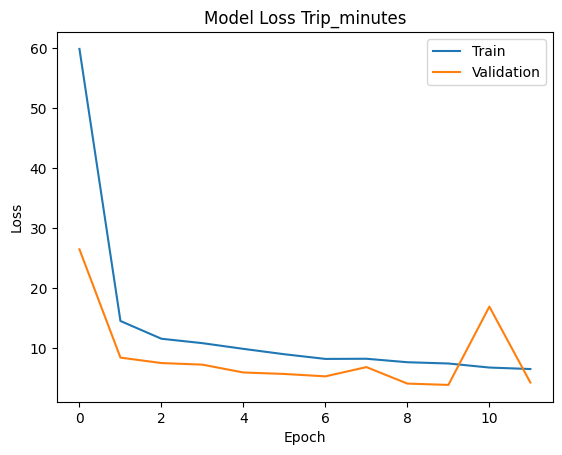

In [110]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Trip_minutes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [33]:
# Guardar el modelo
model_LSTM_min.save('model_LSTM_min.h5')

In [111]:
# Hago que el índice sea un DateTimeIndex
if not isinstance(data_series_LSTM.index, pd.DatetimeIndex):
    data_series_LSTM.index = pd.to_datetime(data_series_LSTM.index)

# Resamplea por mes y suma los valores de 'trip_minutes' para cada mes para evaluar el forecast
suma_trip_minutes_por_mes = data_series_LSTM['trip_minutes'].resample('M').sum()

In [144]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

forecast_min = pd.DataFrame(multi_step_forecast(model_LSTM_min, suma_trip_minutes_por_mes, 12)) # Predice los próximos 12 meses

1/1 [==============================] - 0s 13ms/step


In [155]:
#Entendemos los datos conocidos para enfrentarlos a nuestra predicción
trips_by_month = data_series_LSTM['unlock_date'].resample('M').count()
trips_by_day = data_series_LSTM['unlock_date'].resample('D').count()

In [160]:
#Establecemos cuales serán los elementos del gráfico:
trips_2022_minutes = pd.DataFrame(suma_trip_minutes_por_mes)
prediction_minutes = forecast_min*trips_by_month.mean()

In [130]:
trips_2022_minutes.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/trips_minutes.csv', index=False)
prediction_minutes.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/prediction_minutes.csv', index=False)

In [175]:
trips_by_month.to_xarray

<bound method NDFrame.to_xarray of unlock_date
2022-01-31    1688
2022-02-28    2088
2022-03-31    2056
2022-04-30    2098
2022-05-31    3656
2022-06-30    3358
2022-07-31    2869
2022-08-31    1978
2022-09-30    3193
2022-10-31    3071
2022-11-30    2396
2022-12-31    1550
Freq: M, Name: unlock_date, dtype: int64>

In [164]:
serie = [65021.76, 83687.04, 83329.68, 85325.66, 148360.48, 135495.3, 114673.93, 78170.56, 124878.23, 118878.41, 91910.56, 59225.5]

In [166]:
# Lista de datos
serie = [65021.76,  83687.04,  83329.68,  85325.66,  148360.48,  135495.3,  114673.93,  78170.56,  124878.23,  118878.41,  91910.56,  59225.5]

# Crear un rango de fechas para cada mes del año  2022
fechas = pd.date_range(start='2022-01-01', periods=len(serie), freq='M')

# Crear el DataFrame con las fechas como índice y la serie como datos
df = pd.DataFrame(serie, index=fechas, columns=['Valor'])

print(df)


                Valor
2022-01-31   65021.76
2022-02-28   83687.04
2022-03-31   83329.68
2022-04-30   85325.66
2022-05-31  148360.48
2022-06-30  135495.30
2022-07-31  114673.93
2022-08-31   78170.56
2022-09-30  124878.23
2022-10-31  118878.41
2022-11-30   91910.56
2022-12-31   59225.50


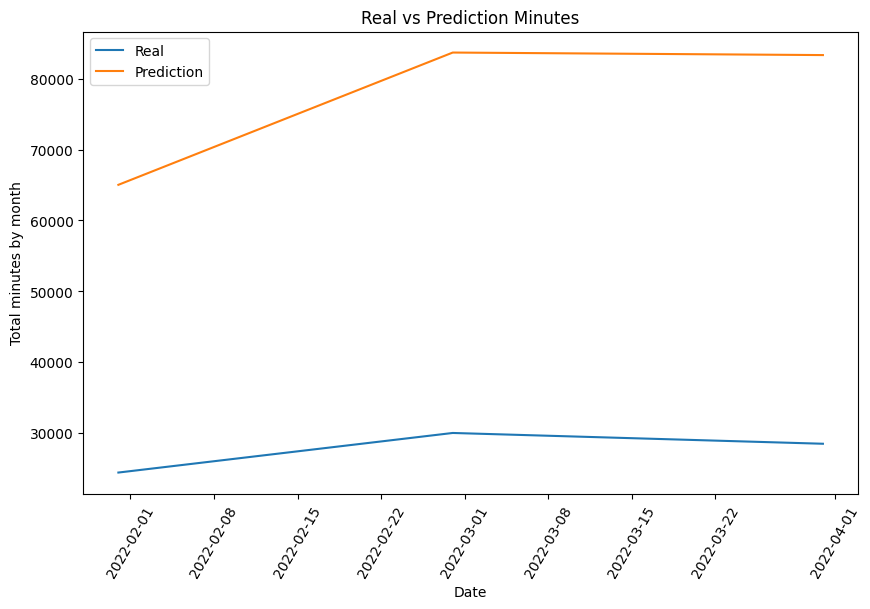

In [190]:
#Gráfico para presentación

plt.figure(figsize=(10, 6))

plt.plot(trips_2022_minutes[:3])
plt.plot(df[:3])
plt.title('Real vs Prediction Minutes')
plt.ylabel('Total minutes by month')
plt.xlabel('Date')
plt.legend(['Real','Prediction'], loc='upper left')
plt.xticks(rotation=60)
plt.show()

# Distance

In [44]:
data_series_LSTM_dis = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'station_unlock',
       'dock_unlock', 'lock_date', 'lock_hour',
       'latitude_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [45]:
data_series_LSTM_dis = data_series_LSTM_dis.set_index(data_series_LSTM_dis['unlock_date'])

In [46]:
data_series_LSTM_dis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30001 entries, 2022-01-01 to 2022-12-31
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   trip_minutes              30001 non-null  float64       
 1   unlock_date               30001 non-null  datetime64[ns]
 2   latitude_unlock           30001 non-null  float64       
 3   longitude_unlock          30001 non-null  float64       
 4   longitude_lock            30001 non-null  float64       
 5   station_lock              30001 non-null  int64         
 6   distance                  30001 non-null  float64       
 7   trip_speed                30001 non-null  float64       
 8   trip_day_of_week_n        30001 non-null  int64         
 9   trip_duration_category_n  30001 non-null  int64         
 10  travel_direction_n        30001 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 2.7 MB

In [47]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01']['distance']
X_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01']['distance']

In [48]:
# Crear el modelo
model_LSTM_dis = Sequential()

# Agregar capas al modelo
model_LSTM_dis.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(LSTM(50, return_sequences=False))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(Dense(25))
model_LSTM_dis.add(Dense(1))

In [49]:
# Crear la instancia de EarlyStopping
early_stopping_dis = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_dis.compile(optimizer='adam',loss='mean_squared_error')
# Entrenar el modelo
history_dis = model_LSTM_dis.fit(X_train_dis, y_train_dis, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dis], verbose=0)

In [50]:
# Evaluar el modelo
train_loss_dis = model_LSTM_dis.evaluate(X_train_dis, y_train_dis, verbose=0)
test_loss_dis = model_LSTM_dis.evaluate(X_test_dis, y_test_dis, verbose=0)

print(f'Train Loss: {train_loss_dis}, Test Loss: {test_loss_dis}')

Train Loss: 0.010716753080487251, Test Loss: 0.010289637371897697


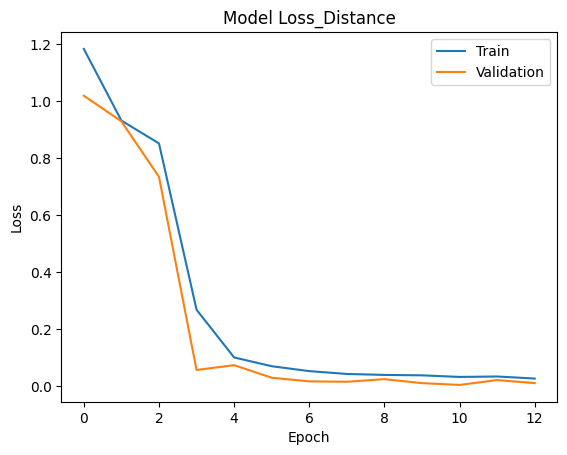

In [51]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_dis.history['loss'])
plt.plot(history_dis.history['val_loss'])
plt.title('Model Loss_Distance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [52]:
# Guardar el modelo
model_LSTM_dis.save('model_LSTM_dis.h5')

In [53]:
# Hago que el índice sea un DateTimeIndex
if not isinstance(data_series_LSTM.index, pd.DatetimeIndex):
    data_series_LSTM_dis.index = pd.to_datetime(data_series_LSTM_dis.index)

# Resamplea por mes y suma los valores de 'trip_minutes' para cada mes para evaluar el forecast
suma_trip_distance_por_mes = data_series_LSTM_dis['distance'].resample('M').sum()

In [75]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

forecast_dis = pd.DataFrame(multi_step_forecast(model_LSTM_dis, suma_trip_distance_por_mes, 12)) # Predice los próximos 12 meses

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


In [69]:
#Entendemos los datos conocidos para enfrentarlos a nuestra predicción
trips_by_month = data_series_LSTM['unlock_date'].resample('M').count()
trips_by_day = data_series_LSTM['unlock_date'].resample('D').count()

In [70]:
#Estableceramos esta media de trayectos por mes:
trips_by_month.mean()

2500.0833333333335

In [203]:
#Establecemos cuales serán los elementos del gráfico:
trips_2022_distance = pd.DataFrame(suma_trip_distance_por_mes)
prediction_distance = forecast_dis*trips_by_month.mean()

In [78]:
trips_2022_distance.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/trips_distance.csv', index=False)
prediction_distance.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/prediction_distance.csv', index=False)

In [195]:
trips_by_month

unlock_date
2022-01-31    1688
2022-02-28    2088
2022-03-31    2056
2022-04-30    2098
2022-05-31    3656
2022-06-30    3358
2022-07-31    2869
2022-08-31    1978
2022-09-30    3193
2022-10-31    3071
2022-11-30    2396
2022-12-31    1550
Freq: M, Name: unlock_date, dtype: int64

In [196]:
forecast_dis.values

array([[ 3.567689 ],
       [ 4.619347 ],
       [ 7.030244 ],
       [ 9.203718 ],
       [10.35541  ],
       [10.78357  ],
       [10.8927145],
       [10.875294 ],
       [10.795025 ],
       [10.659905 ],
       [10.407389 ],
       [ 9.636261 ]], dtype=float32)

In [201]:
# Convertir la Serie en un DataFrame con reset_index para tener un índice numérico

# El array que quieres multiplicar
forecast_min = np.array([[  3.567689 ],
                         [  4.619347 ],
                         [  7.030244 ],
                         [  9.203718 ],
                         [10.35541  ],
                         [10.78357  ],
                         [10.8927145],
                         [10.875294 ],
                         [10.795025 ],
                         [10.659905 ],
                         [10.407389 ],
                         [  9.636261 ]])

# Multiplicar el DataFrame por el array usando mul y broadcasting
result = trips_by_month.mul(forecast_min.flatten(), axis=0)

# Resultado: un DataFrame con la multiplicación elemento a elemento
print(result)


unlock_date
2022-01-31     6022.259032
2022-02-28     9645.196536
2022-03-31    14454.181664
2022-04-30    19309.400364
2022-05-31    37859.378960
2022-06-30    36211.228060
2022-07-31    31251.197900
2022-08-31    21511.331532
2022-09-30    34468.514825
2022-10-31    32736.568255
2022-11-30    24936.104044
2022-12-31    14936.204550
Freq: M, Name: unlock_date, dtype: float64


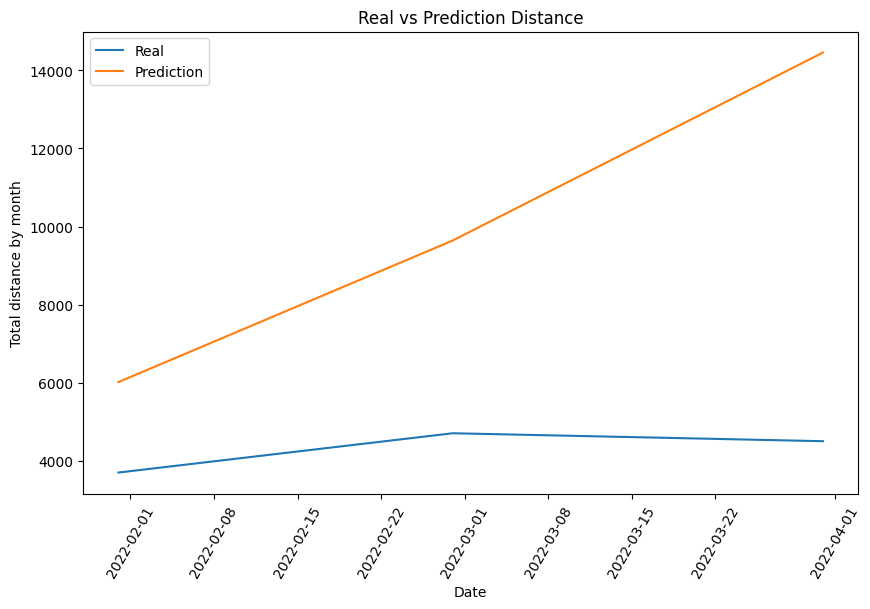

In [207]:
#Gráfico para presentación

plt.figure(figsize=(10, 6))

plt.plot(trips_2022_distance[:3])
plt.plot(result[:3])
plt.title('Real vs Prediction Distance')
plt.ylabel('Total distance by month')
plt.xlabel('Date')
plt.legend(['Real','Prediction'], loc='upper left')
plt.xticks(rotation=60)
plt.show()

# idBike

In [224]:
data_bikes_total = pd.read_csv('/workspaces/BiciMad_4geeks_ML/data/processed/clean_data_trips.csv', sep=',')

In [212]:
# data_series_LSTM_bike = data_series.drop(columns=['idDriver', 'fleet', 
#        'unlock_hour', 'dock_unlock', 'lock_date', 'lock_hour',
#        'latitude_lock', 'dock_lock', 'lock_station_name', 'unlock_station_name'])

In [266]:
data_series_LSTM_bike = data_bikes_total.set_index(data_bikes_total['unlock_date'])

In [267]:
data_series_LSTM_bike.index.name = 'new_index_name'

In [268]:
data_series_LSTM_bike = data_series_LSTM_bike.groupby('unlock_date')['idBike'].nunique().reset_index(name='bikes_used')

In [272]:
data_series_LSTM_bike['unlock_date'] = pd.to_datetime(data_series_LSTM_bike['unlock_date'])

In [273]:
data_series_LSTM_bike = data_series_LSTM_bike.set_index(data_series_LSTM_bike['unlock_date'])

In [274]:
data_series_LSTM_bike.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   unlock_date  365 non-null    datetime64[ns]
 1   bikes_used   365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.6 KB


In [264]:
data_series_LSTM_bike.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   bikes_used  365 non-null    int64
dtypes: int64(1)
memory usage: 13.8+ KB


In [275]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date'])
y_train_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] < '2022-10-01']['bikes_used']
X_test_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date'])
y_test_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] >= '2022-10-01']['bikes_used']

In [276]:
# Crear el modelo
model_LSTM_bike = Sequential()

# Agregar capas al modelo
model_LSTM_bike.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_bike.add(Dropout(0.2))
model_LSTM_bike.add(LSTM(50, return_sequences=False))
model_LSTM_bike.add(Dropout(0.2))
model_LSTM_bike.add(Dense(25))
model_LSTM_bike.add(Dense(1))

In [277]:
# Crear la instancia de EarlyStopping
early_stopping_bike = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_bike.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history_bike = model_LSTM_bike.fit(X_train_bike, y_train_bike, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bike], verbose=0)

In [278]:
# Evaluar el modelo
train_loss_bike = model_LSTM_bike.evaluate(X_train_bike, y_train_bike, verbose=0)
test_loss_bike = model_LSTM_bike.evaluate(X_test_bike, y_test_bike, verbose=0)

print(f'Train Loss: {train_loss_bike}, Test Loss: {test_loss_bike}')

Train Loss: 1606200.0, Test Loss: 1165391.25


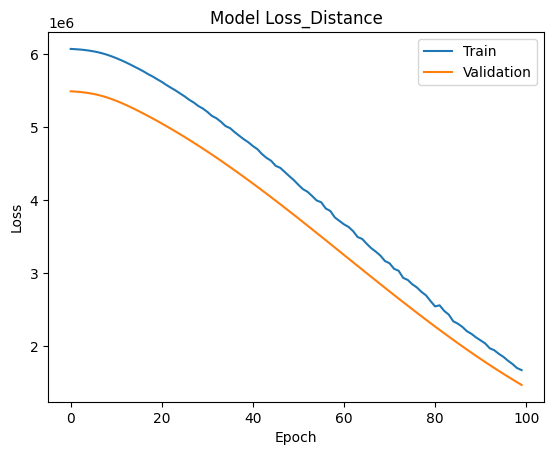

In [279]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_bike.history['loss'])
plt.plot(history_bike.history['val_loss'])
plt.title('Model Loss_Distance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [280]:
# Guardar el modelo
model_LSTM_bike.save('model_LSTM_bike.h5')

In [282]:
data_series_LSTM_bike = data_series_LSTM_bike.drop(columns=['unlock_date'])

In [284]:
# Agrupa por mes y calcula la suma de 'bikes_used'
bikes_by_month = data_series_LSTM_bike.resample('M').sum()

# Muestra los datos agrupados
print(bikes_by_month)

             bikes_used
unlock_date            
2022-01-31        69388
2022-02-28        70032
2022-03-31        71758
2022-04-30        70614
2022-05-31        81780
2022-06-30        79913
2022-07-31        77145
2022-08-31        64535
2022-09-30        74782
2022-10-31        74577
2022-11-30        70386
2022-12-31        61423


In [285]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

forecast_bikes = multi_step_forecast(model_LSTM_bike, bikes_by_month, 12) # Predice los próximos 12 meses

1/1 [==============================] - 0s 13ms/step


In [334]:
#Establecemos cuales serán los elementos del gráfico:
bikes_2022 = pd.DataFrame(bikes_by_month)
prediction_bikes = pd.DataFrame((forecast_bikes/1000*bikes_by_month))

In [337]:
bikes_2022.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/trips_bikes.csv', index=False)
prediction_bikes.to_csv('/workspaces/BiciMad_4geeks_ML/data/graficos/prediction_bikes.csv', index=False)

In [333]:
forecast_bikes

array([[1549.1393],
       [1549.1393],
       [1549.1393],
       [1549.1394],
       [1549.1392],
       [1549.1393],
       [1549.1393],
       [1549.1392],
       [1549.1393],
       [1549.1393],
       [1549.1393],
       [1549.1393]], dtype=float32)

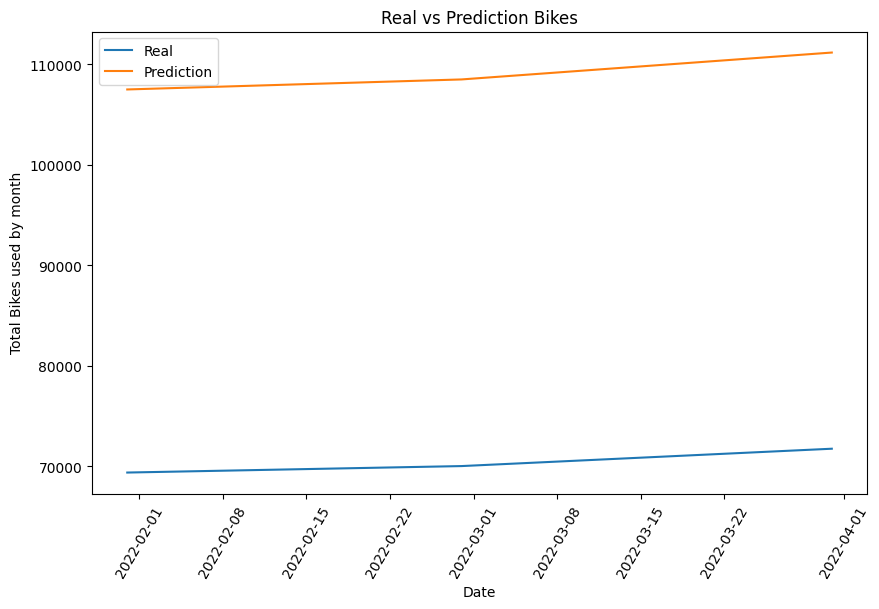

In [339]:
#Gráfico para presentación

plt.figure(figsize=(10, 6))

plt.plot(bikes_2022[:3])
plt.plot(prediction_bikes[:3])
plt.title('Real vs Prediction Bikes')
plt.ylabel('Total Bikes used by month')
plt.xlabel('Date')
plt.legend(['Real','Prediction'], loc='upper left')
plt.xticks(rotation=60)
plt.show()

# Station_unlock

In [51]:
selected_columns = data_series.loc[:, ['station_unlock', 'idBike']]
data_series_LSTM_bike_station_unlock = pd.DataFrame()
data_series_LSTM_bike_station_unlock = selected_columns.groupby([pd.Grouper(freq='D'), 'idBike', 'station_unlock']).size()

In [52]:
data_series_LSTM_bike_station_unlock.head()

unlock_date  idBike  station_unlock
2022-01-01   45      44                1
             517     133               1
             619     32                1
             759     38                1
             1044    38                1
dtype: int64

In [53]:
data_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30001 entries, 2022-01-01 to 2022-12-31
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   idDriver                  15725 non-null  object        
 1   idBike                    30001 non-null  int64         
 2   trip_minutes              30001 non-null  float64       
 3   fleet                     30001 non-null  int64         
 4   unlock_date               30001 non-null  datetime64[ns]
 5   unlock_hour               30001 non-null  int64         
 6   latitude_unlock           30001 non-null  float64       
 7   longitude_unlock          30001 non-null  float64       
 8   station_unlock            30001 non-null  int64         
 9   dock_unlock               30001 non-null  int64         
 10  unlock_station_name       30001 non-null  object        
 11  lock_date                 30001 non-null  object        
 12  l

# Station_lock